# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Задача:Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

План проекта:
- Шаг 1. Откройте файлы с данными
- - 1.1 Импорты
- - 1.2  Открываем файлы с данными
- Шаг 2. Предобработка и исследовательский анализ данных 
- - 2.1  Поиск дубликатов
- - 2.2  Посмотрим распределение значений
- - 2.3  Пропущенные значения
- - 2.4  Работа с датой
- Шаг 3. Формулировка ML-задачи на основе бизнес-задачи
- - 3.1  Функция расчета прибыли
- - 3.2  Прибыль и убытки без внедрения депозитов
- Шаг 4. Разработка модели ML
- - 4.1  Подготовка данных
- - 4.2  Обучаем модели и выбираем лучшую
- - 4.3  Предсказания на тестовой выборке
- - 4.4 Проверка модели на адекватность
- - 4.5  ROC - кривая
- - 4.6  Оценка прибыльности модели
- - 4.7  Расчет итоговой прибыли
- Шаг 5. Опишите портрет «ненадёжного» клиента
- - 5.1  Вес признаков при обучении модели
- - 5.2  Исследовательский анализ для булевых признаков
- - 5.3  Исследовательский анализ для числовых признаков
- Шаг 6. Напишите общий вывод

### Шаг 1. Откройте файлы с данными

#### Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
#####Модели
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
#####Метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

#### Открываем файлы с данными

In [2]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

dfs = [df_train, df_test]

for df in dfs:
    display(df.head(5))
    display(df.info())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

##### Вывод 
Мы видим 2 датасета, один обучающий (для обучения моделей и поиска наиболее подходящей модели под данную задачу), второй тестовый (для предсказаний наилучшей модели). Их мы записали в 2 переменные - df_train и df_test соответственно. В обучающем датасете у нас есть данные по броням за 2015, 2016 год, а в тестовом - за 2017. Так как нам придется в дальнейшем проводить много одинаковых операций по отношению к 2-м датасетам сразу, мы их сразу запиcали в переменную dfs.

### Шаг 2. Предобработка и исследовательский анализ данных

#### Поиск дубликатов

In [3]:
#Поиск явных дубликатов и дубликатов по столбцу 'id'
for df in dfs:
    print(len(df)-len(df.drop_duplicates()))
    print(len(df['id'])-len(df['id'].drop_duplicates()))
print(df_train['reserved_room_type'].unique())

for df in dfs:
    df['reserved_room_type'] = df['reserved_room_type'].str.strip()

print(df_train['reserved_room_type'].unique())

0
0
0
0
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


##### Вывод
Явных дубликатов не выявлено. Дубликатов столбце 'id'(уникальный номер записи) и 'country'(гражданство посетителя) так же нет. Нашли непонятные пробелы в категориях номеров. Удалим их

In [4]:
print(df_train['meal'].unique())
print(df_train['distribution_channel'].unique())
print(df_train['customer_type'].unique())
for df in dfs:
    df['meal'] = df['meal'].str.strip()
print(df_train['meal'].unique())

for df in dfs:
    print(len(df)-len(df.drop_duplicates()))

['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['Direct' 'TA/TO' 'Corporate' 'GDS']
['Transient' 'Contract' 'Transient-Party' 'Group']
['BB' 'FB' 'HB' 'SC']
0
0


#### Посмотрим распределение значений

In [5]:
for column in df_train:
    df_min = df_train[column].min()
    df_max = df_train[column].max()
    print(f'Столбец: {column}, минимальное значение: {df_min}, максимальное: {df_max}')

Столбец: id, минимальное значение: 0, максимальное: 84121
Столбец: is_canceled, минимальное значение: 0, максимальное: 1
Столбец: lead_time, минимальное значение: 0.0, максимальное: 374.0
Столбец: arrival_date_year, минимальное значение: 2015, максимальное: 2016
Столбец: arrival_date_month, минимальное значение: April, максимальное: September
Столбец: arrival_date_week_number, минимальное значение: 1, максимальное: 53
Столбец: arrival_date_day_of_month, минимальное значение: 1, максимальное: 31
Столбец: stays_in_weekend_nights, минимальное значение: 0, максимальное: 4
Столбец: stays_in_week_nights, минимальное значение: 0, максимальное: 6
Столбец: adults, минимальное значение: 0.0, максимальное: 4.0
Столбец: children, минимальное значение: 0.0, максимальное: 3.0
Столбец: babies, минимальное значение: 0.0, максимальное: 10.0
Столбец: meal, минимальное значение: BB, максимальное: SC
Столбец: country, минимальное значение: ABW, максимальное: ZWE
Столбец: distribution_channel, минимальное 

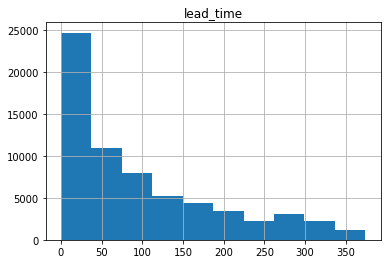

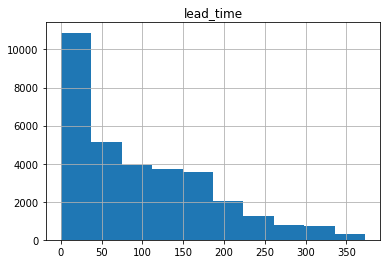

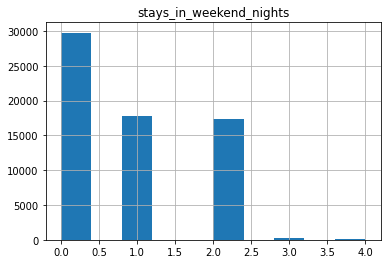

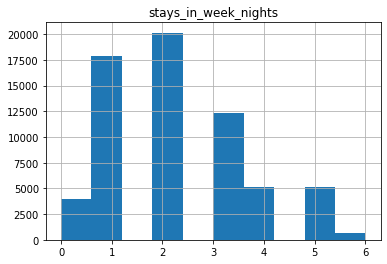

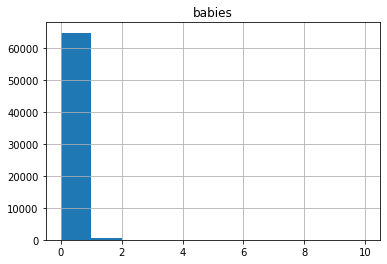

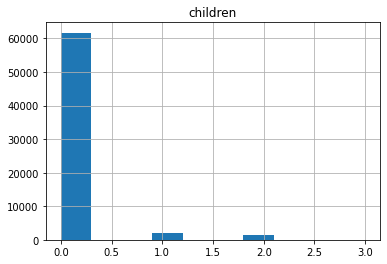

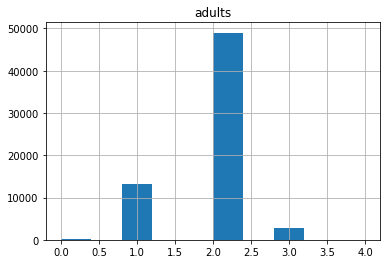

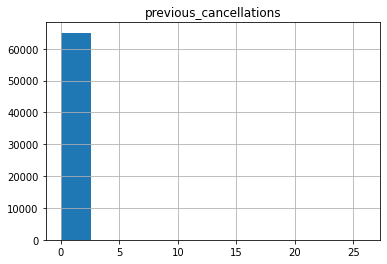

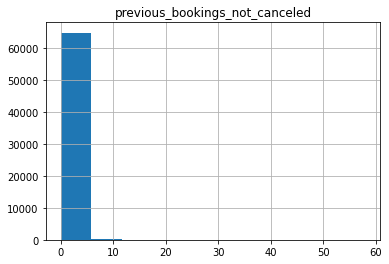

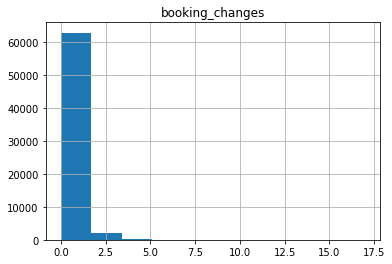

In [6]:
for df in dfs:
    df.hist(column='lead_time')
columns_to_hist = ['stays_in_weekend_nights', 'stays_in_week_nights', 'babies', 'children', 'adults',
                  'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes']
for col in columns_to_hist:
    df_train.hist(column=col)

In [7]:
### Выведем строки с подозрительными значениями
display(df_train[df_train['babies']> 3])
display(df_train[df_train['stays_in_weekend_nights']> 2])
for df in dfs:
    df[df['babies'] <5]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,...,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
71,72,0,92.0,2015,July,27,4,4,6,2.0,...,0,0,0,D,0,0,Contract,0,1,10
72,73,0,92.0,2015,July,27,4,4,6,2.0,...,0,0,0,D,0,0,Contract,0,1,10
97,100,0,82.0,2015,July,28,5,4,6,2.0,...,0,0,0,D,0,0,Transient,1,2,10
98,101,0,94.0,2015,July,28,5,4,6,3.0,...,0,0,0,D,3,0,Transient,1,1,10
190,194,1,97.0,2015,July,29,12,3,5,2.0,...,0,0,0,E,0,0,Transient,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59001,77668,0,125.0,2016,September,37,4,4,6,2.0,...,0,0,0,A,0,0,Transient,0,5,10
60788,79468,0,185.0,2016,October,41,2,3,5,3.0,...,0,0,0,A,0,0,Transient,0,0,8
62169,80868,0,2.0,2016,October,44,24,3,5,2.0,...,0,0,0,A,2,0,Transient,0,0,8
62901,81603,0,44.0,2016,November,45,5,3,6,2.0,...,0,0,0,D,0,0,Transient,0,0,9


##### Вывод
Мы видим, что подозрительное кол-во выходных в отеле всегда сопряжено с большим кол-вом дней в будни, значит клиенты бронировали отель >неделю и здесь с данными все корректно. А вот 10 детей по столбцу babies - явный вброс, так как значения > 2 почти не встречаются.

##### Вывод
Мы видим, что по признаку: 'количество дней между датой бронирования и датой прибытия', значения распределяются нормально и выбросов нет. Есть небольшой скачок между 250 и 300, что составляет ~9 месяцев. Могу связать это с тем, что люди клиенты скорее всего планируют отпуск (в котом им необходимы услуги отеля) в конце календарного года (где то в 11 месяце) на следующий календарный год. Большая часть отпусков приходится на период с 6 по 9 месяца включительно. что как раз и составляет от 7 до 10 месяцев(от 210 до 300 дней), от даты бронирования до даты прибытия.

#### Пропущенные значения

In [8]:
for df in dfs:
    print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [id, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, booking_changes, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, total_nights]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [id, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, booking_changes, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, total_nights]
Index: []

[0 row

In [9]:
display(df.query('total_nights == 0'))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


##### Вывод
Пропущенных значений хотя бы в одной из ячеек 2-х датасетов тоже не наблюдается. Так же в признаке: 'общее количество ночей' нет значений, которые бы были равны 0, значит это количество  забронированных ночей, а не фактических. Тут пропущенных значений тоже нет

#### Работа с датой

In [10]:
mouths = {'January':1,
         'February':2,
         'March':3,
         'April':4,
         'May':5,
         'June':6,
         'July':7,
         'August':8,
         'September':9,
         'October':10,
         'November':11,
         'December':12,
         }

for df in dfs:
    df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: mouths[x])

##### Вывод
Сделаем словарь с числовыми значениями месяцев для вычисления сезонных коэффициентов а так же обучения модели. Вставим значения из словаря в признак: 'месяц заезда'.

In [11]:
for df in dfs:
    print(df.query('total_nights != (stays_in_week_nights+stays_in_weekend_nights)'))
for df in dfs:
    df = df.query('adults != 0 and children > 0')
    df = df.query('adults != 0 and babies > 0')
for df in dfs:
    df = df.drop(columns = ['arrival_date_week_number','arrival_date_year'])





Empty DataFrame
Columns: [id, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, booking_changes, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, total_nights]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [id, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, booking_changes, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, total_nights]
Index: []

[0 row

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Необходимо написать функцию, которая будет счиать прибыль по каждой из уникальных броней. Для удобства напишем еще и функцию, которая считает только убыток по отмененным бронированиям

#### Функция расчета прибыли

In [12]:
autumn = [9,10,11]
summer = [6,7,8]
common_ratio = 1
autumn_ratio = 1.2
summer_ratio = 1.4

price_list = {'A': [1000, 400],
             'B': [800, 350],
             'C': [600, 350],
             'D': [550, 150],
             'E': [500, 150],
             'F': [450, 150],
             'G': [350, 150]
             }

def profit(row):
    mounth = row['arrival_date_month']
    category = row['reserved_room_type']
    days = row['total_nights']
    canceled = row['is_canceled']
    if mounth in autumn:
        ratio = autumn_ratio
    elif mounth in summer:
        ratio = summer_ratio
    else: ratio = common_ratio
    one_day_price = price_list[category][0]*ratio
    clean = price_list[category][1]
    if canceled != 0:
        profit = 0 - (one_day_price+clean)
    else:
        profit = (one_day_price*days) - (clean*(1 +days//2))
    return profit


def canceled_loss(row):
    profit = row['profit']
    if profit > 0:
        loss = 0
    elif profit <= 0:
        loss = profit
    return loss
        


for df in dfs:
    df['profit'] = df.apply(profit, axis = 1)
    df['canceled_loss'] = df.apply(canceled_loss, axis = 1)

##### Вывод
Мы написали 2 функции для подсчета прибыли и убытков с учетом сезонных коэффициентов. Далее применили данные фунции ко всем датасетам, что бы в дальнейшем посмотреть прибыль и сколько денег теряет ежемесячно и ежегодно сеть на отмене забронированных номеров.

#### Прибыль и убытки без внедрения депозитов

In [13]:
pvt = pd.concat(dfs)
percentile_of_loss = (abs(pvt['canceled_loss'])).sum()/(pvt['profit'].sum()+(abs(pvt['canceled_loss'])).sum())
pvt = (
    pd.pivot_table(pvt, values = ['profit', 'canceled_loss'], index = ['arrival_date_year','arrival_date_month'],
                   aggfunc = sum)
       .astype(int)
      )

display(pvt)
print(percentile_of_loss)

canceled_loss   profit
arrival_date_year arrival_date_month                        
2015              7                        -1947940  1612900
                  8                        -2452320  3146330
                  9                        -2969890  3627200
                  10                       -2367310  4374540
                  11                        -632310  2958390
                  12                       -1071400  1729200
2016              1                         -640300  1412100
                  2                        -1568300  2002800
                  3                        -1602150  3781550
                  4                        -2320850  3020250
                  5                        -2082900  3522600
                  6                        -3202990  4752540
                  7                        -1681390  5970280
                  8                        -1825150  5651390
                  9                        -2153550  4399020
                  10                       -2854920  4180730
                  11                       -2108560  3858460
                  12                       -1306800  2478050
2017              1                        -1351100  2176450
                  2                        -1405100  2918600
                  3                        -1708700  3786200
                  4                        -2654650  2981600
                  5                        -2863500  2729750
                  6                        -3315270  4376840
                  7                        -2027370  5035260
                  8                        -1672440  5010310

0.3614389955367269


##### Вывод
Мы видим, что ситуация по отмене номеров плачевная. В одном месяце (Июль 2015) убыток от отмен составил более 50% от общего оборота за месяц. Если брать всю статистику, то этот процент составил ~36% 


### Шаг 4. Разработка модели ML

#### Подготовка данных

In [14]:

#Dummies
df_train = pd.get_dummies(df_train,columns = ['distribution_channel','reserved_room_type','customer_type', 'meal'], drop_first=True)
df_test = pd.get_dummies(df_test,columns = ['distribution_channel','reserved_room_type','customer_type', 'meal'], drop_first=True)

#Сохраним, что бы потом посчитать прибыль
to_append_profit = df_test['profit']
to_append_canceled_loss = df_test['canceled_loss']

#Разбиваем выборки
target_train = df_train['is_canceled']
features_train = df_train.drop(['id','profit', 'canceled_loss', 'is_canceled'], axis = 1)
target_test = df_test['is_canceled']
features_test = df_test.drop(['id','profit', 'canceled_loss', 'is_canceled'], axis = 1)

#Кодирование
encoder = LabelEncoder()
to_encode = features_train['country'].append(features_test['country'])
to_encode = to_encode.unique()
to_encode = pd.Series(to_encode)
encoder.fit(to_encode)

features_train['country'] = encoder.transform(features_train['country'])
features_test['country'] = encoder.transform(features_test['country'])

##### Вывод
У нас есть несколько вариантов кодирования переменных, со своими плюсами и минусами. Сейчас мы воспользуемся 2-мя способами. Это создание дамми переменных и LabelEncoder, который присваивает категориальным переменным число.
Дамми переменные хороши тем, что создают для каждого признака столбец с булевым значением (0/1) это помогает избежать некорректного обучение модели, но создание большого кол-ва столбцов пагубно влияет и на читаемость датасета и на скорость обучения. Поэтому мы применяем данный метод кодирования к признакам с минимальным кол-вом категориальных переменных, но необходимых для поиска взаимосвязей и улучшения точности предсказаний.
LabelEncoder же мы применим к признаку, который содержит в себе более 20 уникальных переменных, это столбец 'country'. В дальнейшем мы так же сможем вернуть предыдущее написание переменных, если вдруг нам будет необходим точный анализ по данному признаку. Итого мы получаем 35 столбцов в каждом дата-сете.

#### Обучаем модели и выбираем лучшую

In [15]:
%%time
models = ['DecisionTreeClassifier', 'LogisticRegression','RandomForestClassifier']

best_model = []
best_result = 0

solvers = ['lbfgs', 'newton-cg','sag', 'saga']
penalties = ['l2', 'none']

for model in models:
    if model == 'DecisionTreeClassifier':
        for depth in range(5, 20, 5):
            for min_samples in range(0,10,2):
                for max_samples in range(6,12,2):
                    model = DecisionTreeClassifier(random_state = 0, max_depth=depth, class_weight='balanced')
                    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='recall')
                    final_score = scores.sum() / len(scores)
                    if final_score > best_result:
                        best_model = model
                        best_result = final_score
                
    if model == 'RandomForestClassifier':
        for est in range(50, 350, 50):
            for depth in range(5, 20, 5):
                model = RandomForestClassifier(random_state= 0, n_estimators = est, max_depth=depth, class_weight='balanced')
                scores = cross_val_score(model, features_train, target_train, cv=5, scoring='recall')
                final_score = scores.sum() / len(scores)
                if final_score > best_result:
                    best_model = model
                    best_result = final_score
                    
    if model == 'LogisticRegression':
        for solv in solvers:
            for penal in penalties:
                model = LogisticRegression(penalty=penal,random_state= 0, class_weight='balanced',solver=solv)
                scores = cross_val_score(model, features_train, target_train, cv=5, scoring='recall')
                final_score = scores.sum() / len(scores)
                if final_score > best_result:
                    best_model = model
                    best_result = final_score





print(f'Лучшая модель:{best_model} c результатом {best_result}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель:LogisticRegression(class_weight='balanced', penalty='none', random_state=0) c результатом 0.653895176784793
CPU times: user 14min 15s, sys: 9min 49s, total: 24min 4s
Wall time: 24min 7s


##### Вывод
Наилучший результат в данной задаче по метрике scores показал классификатор логистической регрессии. Мы сразу записали его в переменную best_model для дальнеших предсказаний и замеров на тестовой выборке.

#### Предсказания на тестовой выборке

In [16]:
model = best_model
best_model.fit(features_train, target_train)
predictions_test = best_model.predict(features_test)

f1 = f1_score(target_test, predictions_test)
accuracy = accuracy_score(target_test, predictions_test)
print(f'Значение метрики f1 на тестовой выборке: {f1}')
print(f'Значение метрики accuracy на тестовой выборке:{accuracy}')
print(classification_report(target_test, predictions_test))

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Значение метрики f1 на тестовой выборке: 0.6423240510392424
Значение метрики accuracy на тестовой выборке:0.7249784030605948
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     19821
           1       0.65      0.64      0.64     12591

    accuracy                           0.72     32412
   macro avg       0.71      0.71      0.71     32412
weighted avg       0.72      0.72      0.72     32412



##### Вывод
Значение точности и полноты предсказаний у нашей модели сбалансированные, о чем и говорит f1-мера. Однако несмотря на гиперпараметр class_weight='balanced' мы не смогли до конца победить дизбаланс классов. Класс '0' Предсказывается лучше, чем класс '1'. (Без отмены или с отменой брони соответственно). Проверим такую модель на адекватность


#### Проверка модели на адекватность

In [17]:
target_pred_constant = pd.Series([0] * len(target_test))
print(f'accuracy_score константной модели: {accuracy_score(target_test, target_pred_constant)}')

accuracy_score константной модели: 0.6115327656423547


##### Вывод
Модель прошла проверку на адекватность. Показатель accuracy лучше, чем у константной модели. 0.73 против 0.61

#### ROC - кривая

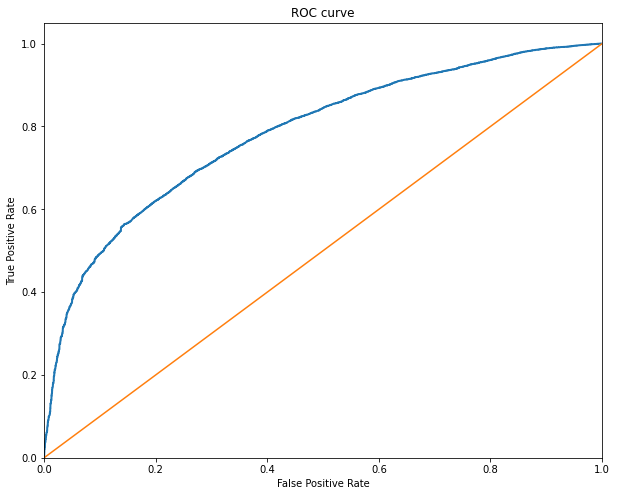

0.7834296726971586


In [18]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
print(roc_auc_score(target_test,probabilities_one_test))

##### Вывод
График ROC (кривая ошибок) тоже говорит об эффективности модели. Запишем итоговые показатели метрик по предсказаниям модели на тестовой выборке:
- accuracy = 0.79
- f1 = 0.65
- auc-roc = 0.79

#### Оценка прибыльности модели

In [19]:
features_test['profit'] = to_append_profit
features_test['canceled_loss'] = to_append_canceled_loss
features_test['predictions'] = predictions_test
features_test['is_canceled'] = target_test

deposit = 0.8

def new_loss(row):
    canceled = row['is_canceled']
    cancel_predict = row['predictions']
    old_loss = row['canceled_loss']
    if canceled == 1 and cancel_predict == 1:
        new_loss =  old_loss*(1-deposit)
    else: new_loss = old_loss
    return new_loss
    
features_test['new_loss'] = features_test.apply(new_loss, axis = 1)
display(features_test)

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,customer_type_Transient,customer_type_Transient-Party,meal_FB,meal_HB,meal_SC,profit,canceled_loss,predictions,is_canceled,new_loss
0,74.0,2017,1,1,1,1,0,2.0,0.0,0.0,...,1,0,0,0,0,-1400.0,-1400.0,1,1,-280.0
1,62.0,2017,1,1,1,2,2,2.0,0.0,0.0,...,1,0,0,0,0,-1400.0,-1400.0,0,1,-1400.0
2,62.0,2017,1,1,1,2,2,2.0,0.0,0.0,...,1,0,0,0,0,-1400.0,-1400.0,0,1,-1400.0
3,71.0,2017,1,1,1,2,2,1.0,0.0,0.0,...,1,0,0,0,0,-1400.0,-1400.0,1,1,-280.0
4,172.0,2017,1,1,1,2,5,2.0,0.0,0.0,...,1,0,0,0,0,-1400.0,-1400.0,0,1,-1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,164.0,2017,8,35,31,2,4,2.0,0.0,0.0,...,1,0,0,0,0,6800.0,0.0,1,0,0.0
32408,21.0,2017,8,35,30,2,5,2.0,0.0,0.0,...,1,0,0,0,0,8200.0,0.0,0,0,0.0
32409,23.0,2017,8,35,30,2,5,2.0,0.0,0.0,...,1,0,0,0,0,8200.0,0.0,0,0,0.0
32410,34.0,2017,8,35,31,2,5,2.0,0.0,0.0,...,1,0,0,0,0,4790.0,0.0,0,0,0.0


##### Вывод
Вернем в датасет столбцы с прибылью и убыками. Так же добавим новый расчет потерь с учетом предсказаний модели.

#### Расчет итоговой прибыли

In [20]:
pvt2 = pd.pivot_table(features_test, values = ['canceled_loss', 'new_loss'], index = ['arrival_date_month'],
                   aggfunc = sum).reset_index()

pvt2['difference'] = (abs(pvt2['canceled_loss']) - abs(pvt2['new_loss'])).astype(int)
display(pvt2)
difference_mean = pvt2['difference'].mean()
difference_sum = pvt2['difference'].sum()
print(f'Средняя прибыль модели за месяц: {difference_mean}')
print(f'Общая прибыль модели за 2017 год: {difference_sum:0}')

,arrival_date_month,canceled_loss,new_loss,difference
0,1,-1351100.0,-762060.0,589040
1,2,-1405100.0,-853860.0,551240
2,3,-1708700.0,-849860.0,858840
3,4,-2654650.0,-1178050.0,1476600
4,5,-2863500.0,-1241540.0,1621960
5,6,-3315270.0,-1321262.0,1994008
6,7,-2027370.0,-1019922.0,1007448
7,8,-1672440.0,-851448.0,820992


Средняя прибыль модели за месяц: 1115016.0
Общая прибыль модели за 2017 год: 8920128


##### Вывод
Такая модель с бюджетом в 400 тысяч окупится менее чем за месяц, особенно эффективно идея внедрения депозитов показывает себя в месяцы с повышенным сезонным коэффициентом. Такая модель может сократить убытки сети отелей около 8 млн. за 8 месяцев прогнозируемого года. И сокращать убытки на более, чем 1 млн каждый месяц.

### Шаг 5. Опишите портрет «ненадёжного» клиента

#### Вес признаков при обучении модели

,features,feature_importances
29,customer_type_Transient,0.630247
12,previous_cancellations,0.604776
21,distribution_channel_TA/TO,0.400772
7,adults,0.198717
33,meal_SC,0.137706
24,reserved_room_type_D,0.063723
5,stays_in_weekend_nights,0.056215
8,children,0.053987
31,meal_FB,0.026485
18,total_nights,0.018746


<AxesSubplot:title={'center':'Feature Importance'}, ylabel='features'>

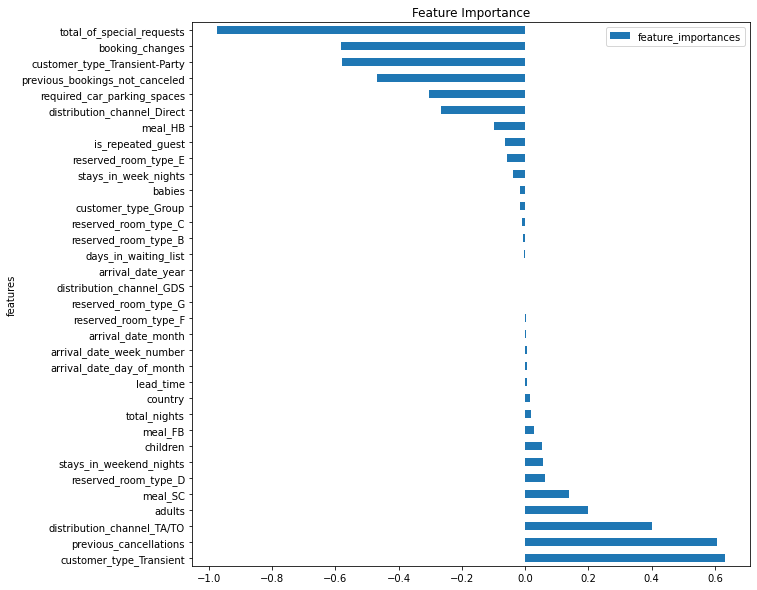

In [21]:
feature_importances = best_model.coef_[0]
features_df = pd.DataFrame({'features':list(features_train),
    'feature_importances': feature_importances}).sort_values(by='feature_importances', ascending = False)
display(features_df)

feature_importances = pd.Series(feature_importances)
features_df.plot.barh(x = 'features', y ='feature_importances',title = 'Feature Importance',figsize=(10,10))

##### Вывод
Достали 'вес' признаков из модели, то есть те, которые модель считает наиболее весомыми. Рассмотрим 6 из них более детально.

#### Исследовательский анализ для булевых признаков

In [22]:

columns_to_analyse = ['customer_type_Transient', 'distribution_channel_TA/TO', 'customer_type_Transient-Party']

mean = features_test['is_canceled'].mean()

print(f'Средний процент отказавшихся от брони по всем данным за 2017 год: {mean}')

for column in columns_to_analyse:
    display(pd.pivot_table(features_test, index = column, values = 'is_canceled',aggfunc='mean'))


Средний процент отказавшихся от брони по всем данным за 2017 год: 0.3884672343576453


,is_canceled
customer_type_Transient,
0,0.158756
1,0.429882


,is_canceled
distribution_channel_TA/TO,
0,0.196472
1,0.426245


,is_canceled
customer_type_Transient-Party,
0,0.423727
1,0.165575


##### Вывод
Мы видим, что за 2017, около 39% клиентов отказываются от брони. Рассмотрим процентное распределение внутри каждого 'весомого' признака. Тут мы уже можем выделить взаимосвязи:
- Если тип заказчика 'Transient-Party' вероятность отмены брони уже резко падает до 16%
- Если канал дистибуции заказа не 'TA/TO' то вероятность отмены брони падает 19%

#### Исследовательский анализ для числовых признаков

------------------------------
Измерения по призанку: previous_cancellations


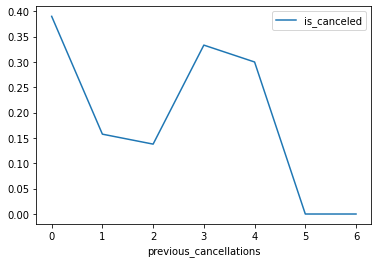

,previous_cancellations,is_canceled
0,0,0.390108
1,1,0.157576
2,2,0.137931
3,3,0.333333
4,4,0.300000
5,5,0.000000
6,6,0.000000


------------------------------
------------------------------
Измерения по призанку: booking_changes


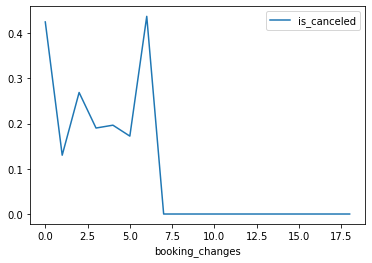

,booking_changes,is_canceled
0,0,0.425086
1,1,0.130179
2,2,0.268966
3,3,0.190299
4,4,0.196581
5,5,0.172414
6,6,0.437500
7,7,0.000000
8,8,0.000000
9,10,0.000000


------------------------------
------------------------------
Измерения по призанку: total_of_special_requests


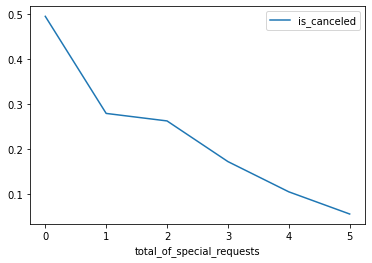

,total_of_special_requests,is_canceled
0,0,0.494578
1,1,0.278968
2,2,0.262287
3,3,0.171996
4,4,0.104839
5,5,0.055556


------------------------------


In [23]:
columns_to_analyse = ['previous_cancellations', 'booking_changes','total_of_special_requests']
for column in columns_to_analyse:
    print('------------------------------')
    print(f'Измерения по призанку: {column}')
    pt = pd.pivot_table(features_test, index = column, values = 'is_canceled',aggfunc='mean').reset_index()
    pt.plot(x=column)
    plt.show()
    display(pt)
    print('------------------------------')



##### Вывод
Опишем выводы по каждому из признаков:

<ol>
<li>previous_cancellations (количество отменённых заказов у клиента) - Мы видим, что среди людей, которые никогда не отменяли брони % отмены распределяется почти так же как и по всему датасету (39% и 38%), но далее можно сделать контринтуитивный вывод, а именно: вероятность, что клиент отменит бронь, если он уже её отменял 1 раз становится меньше, чем если бы отмен не было, а именно 16%. Если 2 раза - еще меньше 14%. Исследований с признаком > 2 слишком мало,что бы сделать выводы. Остановимся на этом.</li>

<li>booking_changes (количество изменений параметров заказа) - здесь мы видим V образное распределение данных. Это означает, что если изменений параметров заказа не было, или их было слишком много (>5) - вероятность отмены заказа высокая. Таким образом наименьшую вероятность отмены брони составляют переменные признака, которые попадают в данный диапазон: от 0 до 5
</li>

<li>total_of_special_requests (количество специальных отметок) - здесь стабильно убывающий график. Т.е. При увеличении числа специальных отметок уменьшается вероятность отмены заказа, при чем диапазон вероятностей начинается с 49% и заканчивается 6%.
Это можно связять с тем, что клиенты, которые более точно и осмысленно склонны планировать свой комфорт во время пребывания в отеле так же более осмысленно принимают решения о бронировании номера и не склонны это решение менять.</li>
</ol>

### Шаг 6. Напишите общий вывод

<i>И так мы выяслили, что наш классификатор логистической регрессии может сократить убытки сети отделей более чем на 1 млн. в месяц, со сроком окупаемости менее, чем за 1 месяц. Так же теперь мы можем составить примерный портрет клиента, который с наименьшей вероятностью откажется от бронирования номера. это:
- Клиент, который точно знает, что хочет получить от пребывания в отделе и вносит большое кол-во специальных отметок
- Клиент, который изменит параметры заказа в уже забронированном номере, но не слишком много раз (от 1 до 5)
- Тип клиента 'Transient-Party'
- Канал, с которого пришел клиент не TA/TO

Выведем средний % отказа по таким клиентам:
<i>

In [24]:
best_client = features_test[features_test['distribution_channel_TA/TO']!= 1]
best_client = best_client[best_client['total_of_special_requests']>= 1]
best_client = best_client[best_client['previous_cancellations']>0]
best_client = best_client[best_client['booking_changes'] > 0]
best_client = best_client[best_client['booking_changes'] < 6]
print(len(best_client))
best_client['is_canceled'].mean()

33


0.030303030303030304

<i> Количество условий немного сократили, так как исследований сликом мало, но мы уже видим, что по 33 клиентам, которые попали под условия выше процент отказа составляет около 3%<i>

<i> Теперь перейдем к параметрам, которые либо слабо, либо никак не влияют на 'надежность' клиента:
- Тип питания, который выбирает клиент
- Страна, из которой пребывает клиент
- Дни, в которые клиент будет пользоваться услугами отеля (будни/выходные)
- Количество дней между датой бронирования и датой прибытия
- Сколько дней заказ ожидал подтверждения
<i>